In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
config = {
    "base_dir":        "/eos/home-b/bpinolin/ML_output/",
    "plot_config":     "VBSOS",
    "cut":             "sr",
    "model_version":   "highZ/v4/v0",
    "batch_size": 512,
    "test_size": 0.2,
}

In [3]:
sample = "highZ_test"

In [4]:
import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])

In [5]:
import yaml
model_config_file = open(model_dir + "/model_config.yml", "r")
model_config = yaml.safe_load(model_config_file)

for key in ["samples_version", "cols"]:
    config[key] = model_config[key]

In [6]:
# load numpy
#samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples/", sample)
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

In [7]:
samples_dir

'/eos/home-b/bpinolin/ML_output/VBSOS/sr/samples/highZ_test'

In [8]:
bkg = bkg.dropna()
signal = signal.dropna()

In [9]:
signal["log(mjj)"] = np.log(signal['mjj'])
bkg["log(mjj)"] = np.log(bkg['mjj'])

signal["log(jetpt1)"] = np.log(signal['jetpt1'])
bkg["log(jetpt1)"] = np.log(bkg['jetpt1'])

signal["log(jetpt2)"] = np.log(signal['jetpt2'])
bkg["log(jetpt2)"] = np.log(bkg['jetpt2'])

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [11]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight_"]).values
Wnn_bkg = (bkg["weight_"]).values

X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

scaler = pickle.load(open(f"{model_dir}/scaler_model.pkl", "rb"))
X_scaled = scaler.fit_transform(X)

In [12]:
import tensorflow as tf

model = tf.keras.models.load_model(os.path.join(model_dir, "model.h5"))

model.summary()

W1220 20:10:10.369606 140607137838912 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                1050      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 4,051
Trainable params: 3,851
Non-trainable params: 200
_________________________________________________________________


In [13]:
y_pred = model.predict(X_scaled, batch_size=config["batch_size"])
y_pred = np.array(y_pred).flatten()

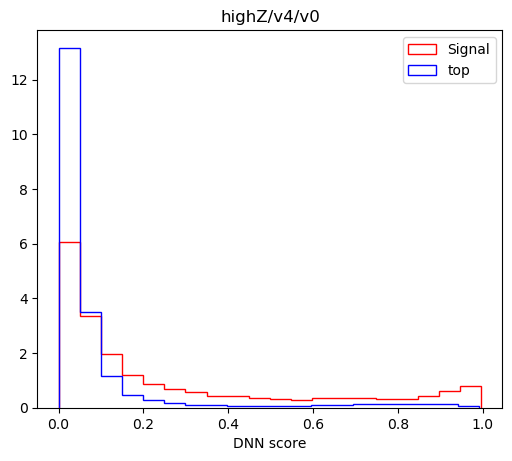

In [14]:
fig = plt.figure(figsize=(6,5), dpi=100)
_ = plt.hist(y_pred[Y==1], bins=20, lw = 1, histtype="step", label="Signal", color='red', density=True)
_ = plt.hist(y_pred[Y==0], bins=20, lw = 1, histtype="step", label="top", color='blue', density=True)
plt.legend(loc="upper right", fontsize=10)
plt.xlabel("DNN score", fontsize=10)
plt.title(config["model_version"])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig(os.path.join(model_dir, "plots/DNN_score.pdf"))
plt.savefig(os.path.join(model_dir, "plots/DNN_score.png"))
plt.show()

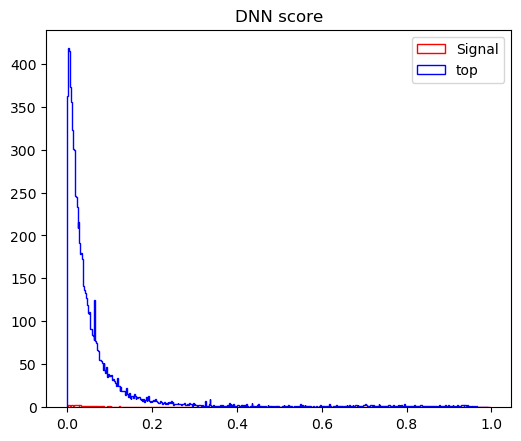

In [15]:
fig = plt.figure(figsize=(6,5), dpi=100)
n_sig, b, _ = plt.hist(y_pred[Y==1], bins=500, histtype="step", weights=Wnn[Y==1], label="Signal", color='red')
n_bkg, b, _ = plt.hist(y_pred[Y==0], bins=500, histtype="step", weights=Wnn[Y==0], label="top", color='blue')
plt.legend()
plt.title("DNN score")
plt.show()

In [16]:
effS = np.array([])
effB = np.array([])

for i in range(len(n_sig)):
    i = i+1
    S = sum(n_sig[-i:len(n_sig)])
    effS = np.append(effS, S/sum(n_sig))
    
for j in range(len(n_bkg)):
    j = j+1
    B = sum(n_bkg[-j:len(n_bkg)])
    effB = np.append(effB, B/sum(n_bkg))

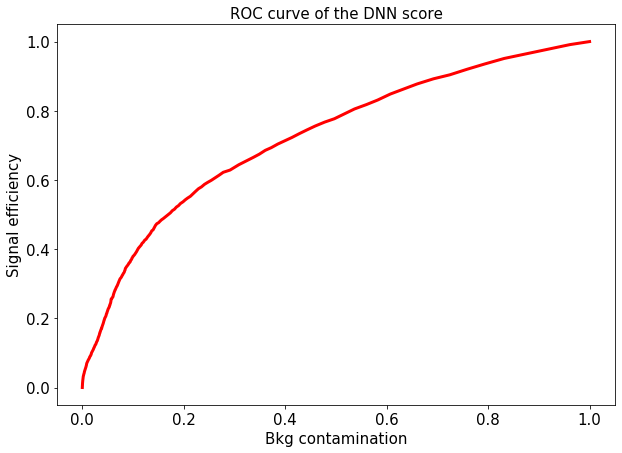

In [17]:
plt.figure(figsize=(10,7))
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.xlabel("Bkg contamination", fontsize=15)
plt.ylabel("Signal efficiency", fontsize=15)

plt.title("ROC curve of the DNN score", fontsize=15)
plt.plot(effB,effS,linewidth=3, color="red")
plt.show()

In [18]:
B = effB.tolist()
B.insert(0,0)

In [19]:
S = effS.tolist()
S.insert(0,0)

In [20]:
print(B)
print(S)

[0, 1.701420945467721e-05, 1.8824239453022272e-05, 1.8824239453022272e-05, 2.6988249024494093e-05, 3.1929261731730444e-05, 3.9365885548358316e-05, 0.00012057157997326991, 0.00013924607214360596, 0.00016237113893026776, 0.0002134978706197699, 0.0002666402839214892, 0.0003141670664572582, 0.00034490007876430555, 0.00044929714318287417, 0.0005189218155404906, 0.0006777931261844666, 0.000777515817024742, 0.0008646986581322013, 0.000992396778935259, 0.0011272582903998722, 0.0012167977691521982, 0.0013333020650655473, 0.0015142239020726354, 0.0016329786872396218, 0.0018740808781666741, 0.0020630722414653494, 0.0022991788257744217, 0.0025544144425918053, 0.0027657882753217575, 0.003033052873164941, 0.0032906942971388286, 0.0035819533344776918, 0.003792453256391374, 0.003970921382183367, 0.0041149848554331075, 0.004277984389207615, 0.004507566542875708, 0.004639728401224474, 0.004731557476008338, 0.004916036757053119, 0.0051355491026516915, 0.005379631528429438, 0.005497493536096434, 0.0056408

## 2D plots: DNN vs btag_central